# Table of Contents

- [RNN Review](#RNN-Review)
- [LSTM](#LSTM)
- [GRU](#GRU)
- [Time Series Example](#Time-Series-Example)
- [Exercises](#Exercises)

## Housekeeping



-   Some references I've been giving throughout the course
    -   <span class="underline">[Official pytorch tutorials](https://pytorch.org/tutorials/)</span>
        -   Example and exercise today comes from the pytorch tutorial on rnn
    -   [Deep Learning Book, Ch.10 on RNN](https://www.deeplearningbook.org/contents/rnn.html)
    -   [<span class="underline">Dive Into Deep Learning Ch. 8, RNN</span>](https://d2l.ai/chapter_recurrent-neural-networks/index.html)
    -   [<span class="underline">RNN chapter of Hands-On Machine Learning</span>](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch15.html#idm45728453105336)
-   Today's url
    -   [https://git.io/ml2021-11](https://git.io/ml2021-11)
-   Email if you need help!
-   Today, we'll use the built-in pytorch RNN layer, and see some extensions



## RNN Review



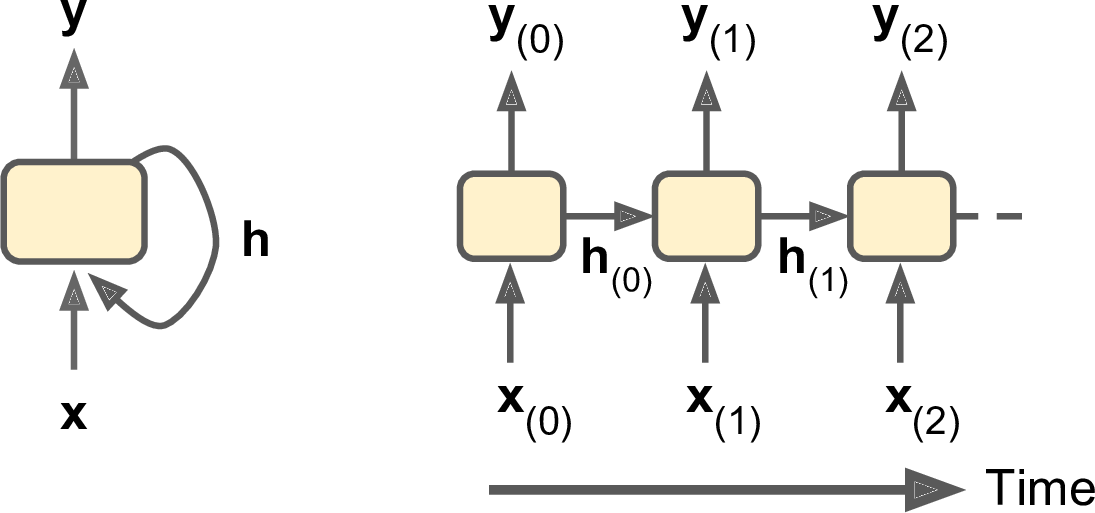

In [ ]:
Image("mls2_1503.png")

-   Recall from last week:
    -   An RNN operates on a sequence of data $x_{(i)}$, where $i$ indexes time
        -   E.g. letters in a word, or words in a sentence, or datapoints
            from a timeseries (stock market prices for example)
        -   It looks at one timestep at a time, updating hidden state
            $h_{(i)}$ which keeps information about the context
        -   It also gives some output, which we might want to keep at each
            timestep (e.g. stock market prices), or discard until the end
            (e.g. our word to country name example last week)

## MultiLayer RNN

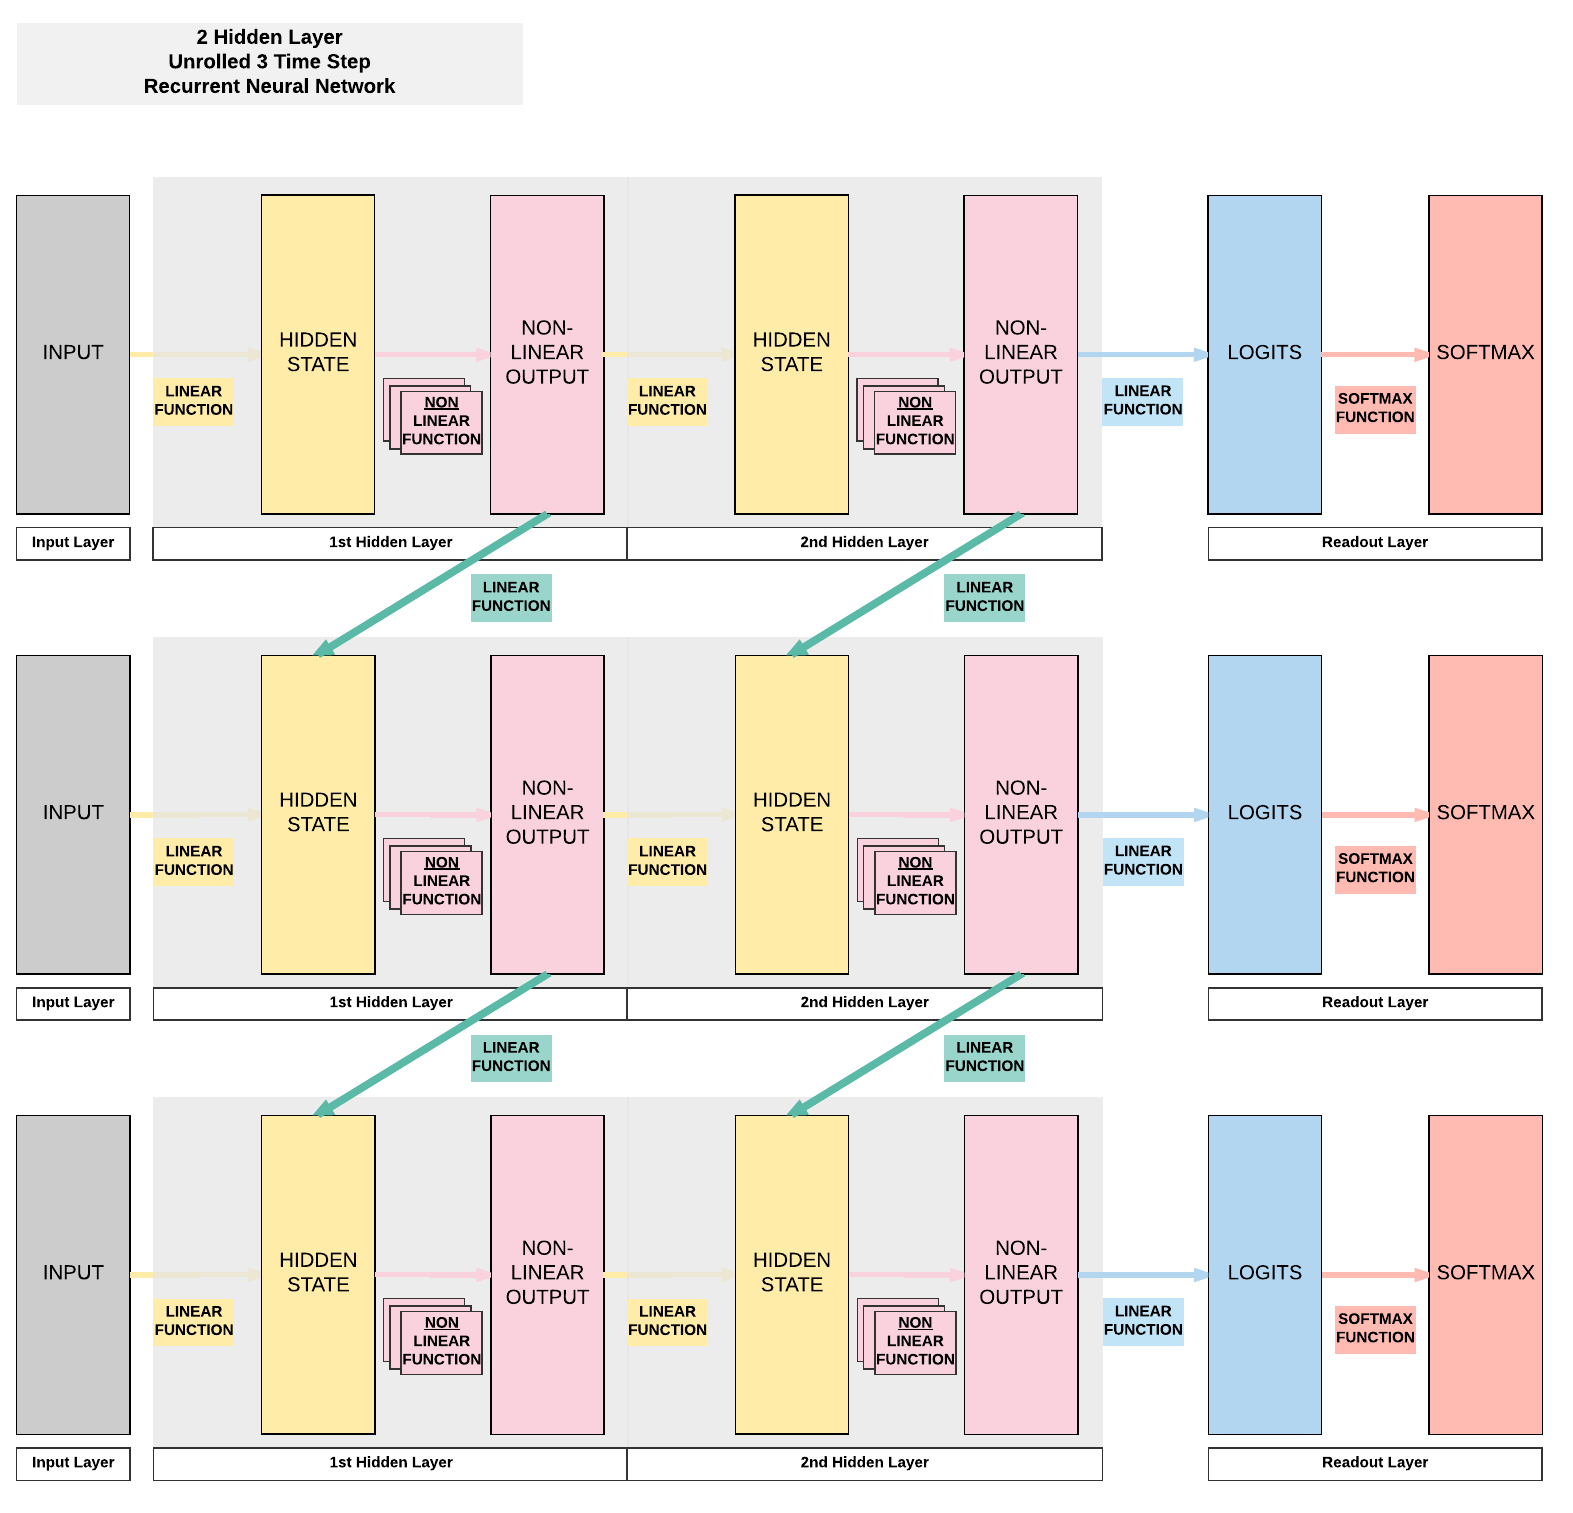

In [ ]:
Image("rnn5nr.png")

-   We also saw that we can have our RNN use multiple layers, keeping
    the hidden state of each layer separately

## RNN in PyTorch

-   There is a `torch.nn.RNN` module which is able to setup these details
    -   One difference from last week: the hidden state and the output
        state are the same in the `nn.RNN` setup (no separate "output")
-   It also can take in and process several timesteps at once

In [ ]:
rnn = torch.nn.RNN(inputs_size, hidden_size, n_layers, 
                   batch_first=False)

-   creates a network which takes in a tensor `(seq_len, batch_len, inputs_size)` 
    (or `(batch_len, seq_len, inputs_size)` if `batch_first=True`)
    -   `seq_len` is the dimension for the number of timesteps you're
        passing into the network, note that this means for a single batch
        of inputs, you should have the same number of timestamps for each input
        -   You could e.g. sort the dataset by number of timesteps for a
            name dataset, or choose a fixed number of input timesteps for a
            time series
-   The output is a tuple:
    -   1st: shape `(seq_len, batch, hidden_size)` containing the output
        features from the final layer of the RNN for each element in the
        seq
        -   (batch/seq reversed if  `batch_first=True`)
    -   2nd: a list length `seq_len` with each element shape `(num_layers,
            batch, hidden_size)` containing the complete **final** hidden state
- It will wrap up an `n_layers` RNN structure with each layer computing $h_t = \tanh (W_h x_t + W_h h_{t-1} + b)$ for $x_t$ the input from the previous layer (or input), and $h_t$ the new hidden state
- Note also, its wrapping up the details of the hidden state. It gives you it as output, and you can input it into the network like we did last week, but if you don't give it anything, it assumes a new sequence and starts from a 0 hidden state
- Note also last week we passsed the sequence in one at a time, here will we process the whole sequence as a single step

## RNN

-   We have a RNN consisting of several layers, of the same number of
    hidden nodes, and a final **decode** layer, which reads the final
    output and connects it to a vector of the output size (basically this is just the structure we made last week, but using `torch.nn.RNN` to wrap up the details)

In [ ]:
import torch
import torch.nn as nn
class MyRNN(nn.Module):
  def __init__(self, n_input=20, n_hidden=128, n_layers=2, n_outputs=10):
    super(MyRNN, self).__init__()
    self.rnn = nn.RNN(n_input, n_hidden, n_layers, batch_first=True)
    self.decode = nn.Linear(n_hidden, n_outputs)
  def forward(self, x, skip_decoding=False):
    output, hidden = self.rnn(x) # automatic zeros for initial hidden state
    if not skip_decoding:
      output = self.decode(output[:,-1,:]) # take only the last hidden state
    return output, hidden

rnn = MyRNN()
test = torch.randn( 12, 5, 20 ) # batch of 12 inputs, each of length (# timesteps) 5, with 20 features / step
output = rnn(test, skip_decoding=True)
print(test.shape, len(output), output[0].shape, output[1].shape)
output = rnn(test, skip_decoding=False)
print(test.shape, len(output), output[0].shape, output[1].shape)

torch.Size([12, 5, 20]) 2 torch.Size([12, 5, 128]) torch.Size([2, 12, 128])
torch.Size([12, 5, 20]) 2 torch.Size([12, 10]) torch.Size([2, 12, 128])

The more advanced networks follow this same basic structure, if you
don't understand, now is the time to ask

## LSTM

![img](https://github.com/uos-computing-for-particle-physics/11-more-rnn-nyw-pathfinder/blob/master/Slide13-1.JPG?raw=1)

-   A Long Short-term Memory or LSTM layer is an RNN augmented with "long-term memory"
-   The idea is the RNN is always required to be continuously updating its state
    -   Makes it easy for the RNN to "forget" context, earlier information can be wiped out in updates
    -   LSTM adds a long-term memory which "remembers" "important" "context"
    -   It has also a "working memory" which works like the RNN hidden state
        -   The "short term" part of "Long Short-term Memory"
-   The long-term memory keeps important information around, the
    short-term scratchpad keeps only short time-scale correlations

[https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/](https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/)

## How the LSTM Works

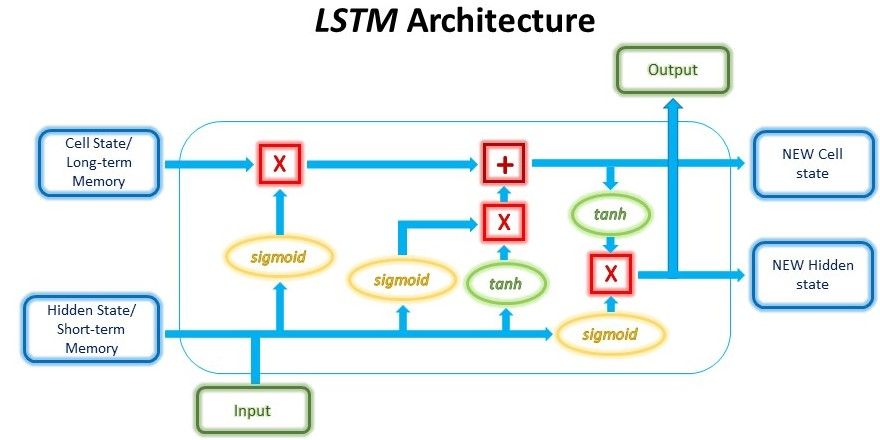

In [ ]:
Image("Slide19.JPG")

-   LSTM works by *gating* information as it runs through the network
    -   Filters out important parts of the data (learnt with the usual
        weights matrix) using sigmoid to turn things on/off
-   There are *two* sets of memory: "cell" state = long-term memory, "hidden" state, similar to vanilla RNN
-   Input gate: filter and selects important parts of input
-   Forget gate: filter out current cell, basically deciding which parts
    of long-term memory to "forget" and update with new information
-   Output gates: update final cell, hidden and output

## How the LSTM Works

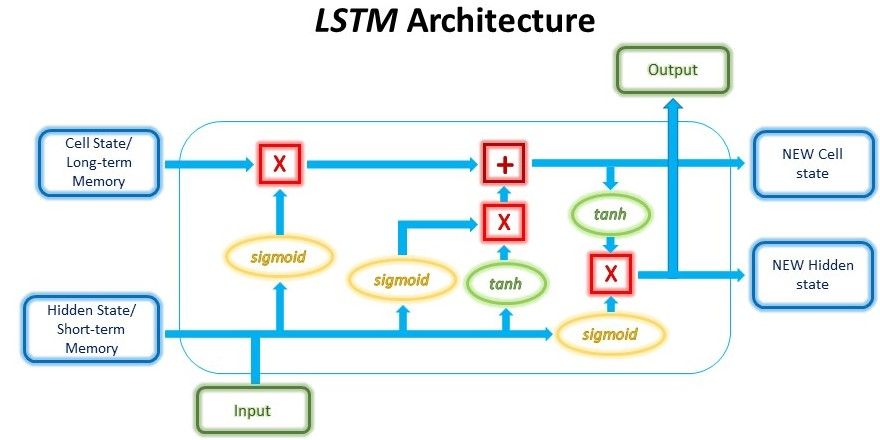

In [ ]:
Image("Slide19.JPG")

- In the picture, when paths join, your concatenating the vectors
- Each of the activations has an implicit weight matrix and bias associated to it (these are what we optimize)
- sigmoid and times acts to filter out states (so they may be updated)
- tanh gates are to set values
- As for the pytorch RNN the output of the LSTM will be the hidden state, while here the hidden and cell states are kept

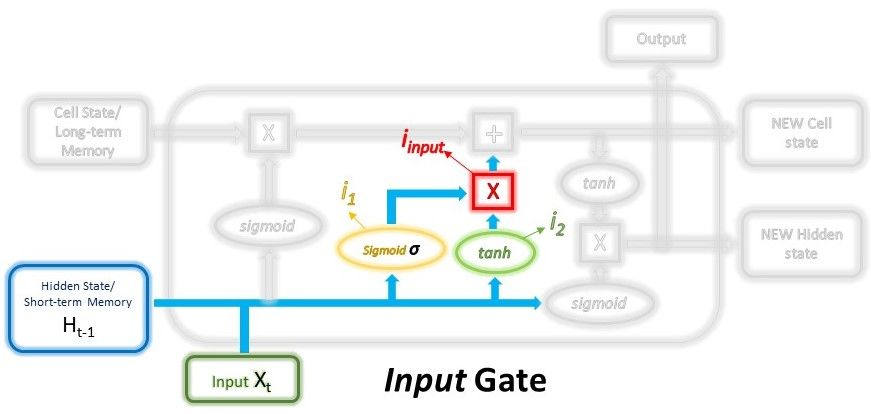

In [ ]:
Image("Slide20.JPG")

-   Input gate: $i_1 = \sigma(W_{i1} \cdot (h_{t-1},x_t) + b_{i1})$ filter and selects input
    $i_2 = \tanh(W_{i2} \cdot (h_{t-1},x_t) + b_{i2})$  state activation from input

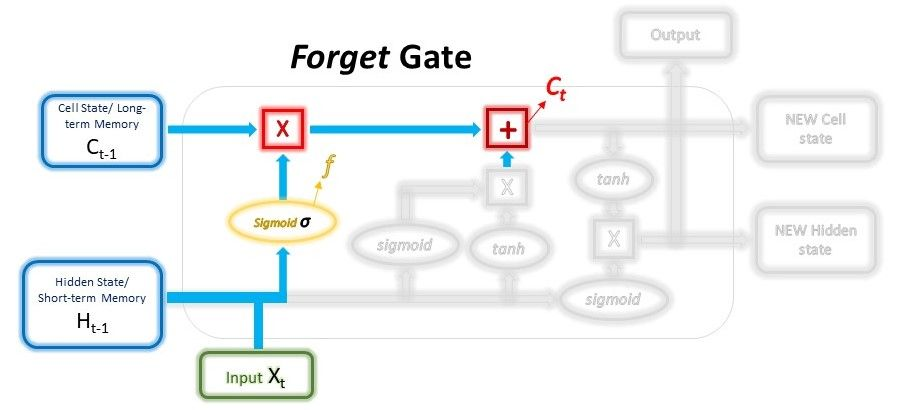

In [ ]:
Image("Slide21.JPG")

-   Forget gate: $f = \sigma(W_{f} \cdot (h_{t-1},x_t) + b_f)$ filter out current cell

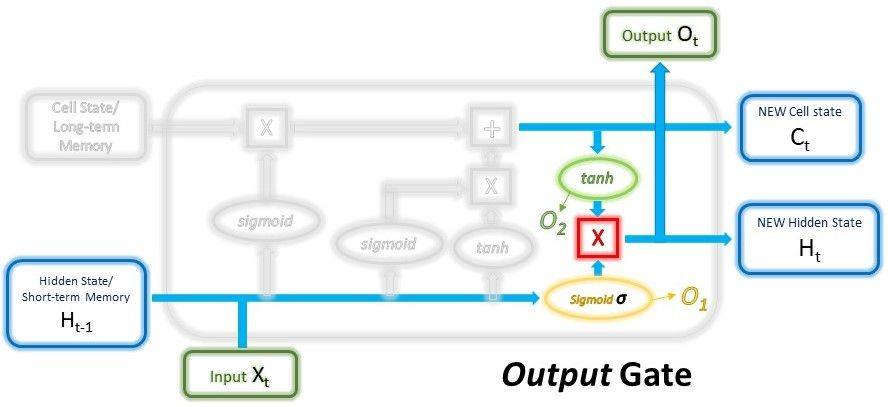

In [ ]:
Image("Slide22.JPG")

-   Cell update: $c_t = c_{t-1} \odot f + i_1 \odot i_2$ add previous and new states
-   Output gate: $o_1 = \sigma(W_{o1} \cdot (h_{t-1},x_t) + b_{o1}) $, filter for hidden/output
    $o_2 = \tanh(W_{o2} \cdot c_t + b_{o2}) $, hidden/output activation   
    $h_t, o_t = o_1 \odot o_2$ final hidden and output

## GRU

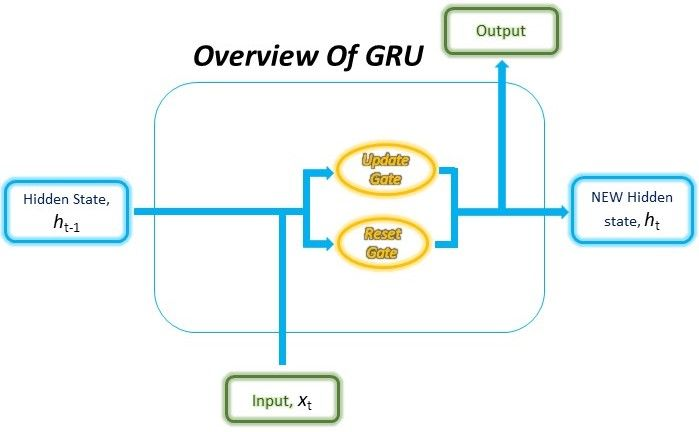

In [ ]:
Image("image17-1.jpg")

-   A simplified version of LSTM, proposed in 2014 vs 1997 for LSTM
-   It only contains a single hidden state, but has a similar "forget"
    mechanism to LSTM
    - As opposed to basic RNN where we must update for each sequence, the network can "choose" what to update
-   More computationally efficient, but has similar performance to LSTM

## GRU

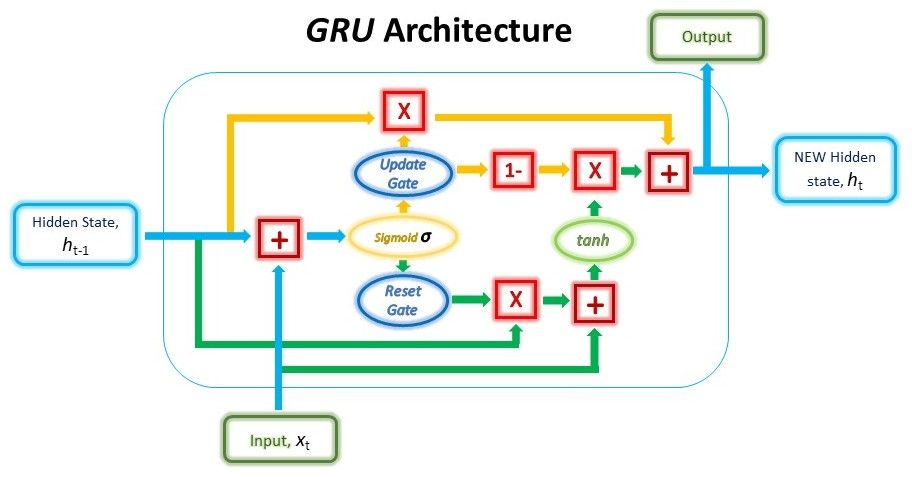

In [ ]:
Image("image14.jpg")

-   Mathematically, GRU calculates the following:
    -   Reset gate: $r_t = \sigma(W_{ir}x_t+b_{ir}+W_{hr} h_{t-1}+b_{hr})$
    -   Update gate: $z_t = \sigma(W_{iz}x_t+b_{iz}+W_{hz} h_{t-1}+b_{hz})$
    -   Proposed state: $n_t=\tanh(W_{in}x_t+b_{in}+r_t \odot (W_{hn} h_{t-1}+b_{hn}))$
    -   New hidden state $h_t=(1-z_t) \odot n_t+z_t \odot h_{t-1}$
-   The new hidden state is also used as the output
    - So, the update gate (from hidden + input) is deciding what part of the current state to keep, and which to update from the new proposed state
[https://blog.floydhub.com/gru-with-pytorch/](https://blog.floydhub.com/gru-with-pytorch/)

## GRU in pytorch: `nn.GRU`

-   GRUs act the same as RNN from the point of view of the user. The
    only difference in the code is `nn.RNN` is replaced with `nn.GRU`

In [ ]:
import torch
import torch.nn as nn
class MyGRU(nn.Module):
  def __init__(self, n_input=20, n_hidden=128, n_layers=2, n_outputs=10):
    super(MyGRU, self).__init__()
    self.gru = nn.GRU(n_input, n_hidden, n_layers, batch_first=True)
    self.decode = nn.Linear(n_hidden, n_outputs)
  def forward(self, x, skip_decoding=False):
    output, hidden = self.gru(x) # automatic zeros for initial hidden state
    if not skip_decoding:
      output = self.decode(output[:,-1,:]) # take only the last hidden state
    return output, hidden

gru = MyGRU()
test = torch.randn( 12, 5, 20 ) # batch of 12 inputs, each of length (# timesteps) 5, with 20 features / step
output = gru(test, skip_decoding=True)
print(test.shape, len(output), output[0].shape, output[1].shape)
output = gru(test, skip_decoding=False)
print(test.shape, len(output), output[0].shape, output[1].shape)

torch.Size([12, 5, 20]) 2 torch.Size([12, 5, 128]) torch.Size([2, 12, 128])
torch.Size([12, 5, 20]) 2 torch.Size([12, 10]) torch.Size([2, 12, 128])

## nn.LSTM



-   LSTM **almost** act the same as RNN
    -   The hidden output is a tuple of `(hidden, cell)`, or (short-term state, long-term state)



In [5]:
import torch
import torch.nn as nn
class MyLSTM(nn.Module):
  def __init__(self, n_input=20, n_hidden=128, n_layers=3, n_outputs=10):
    super(MyLSTM, self).__init__()
    self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True)
    self.decode = nn.Linear(n_hidden, n_outputs)
  def forward(self, x, skip_decoding=False):
    output, hidden = self.lstm(x) # automatic zeros for initial hidden state
    if not skip_decoding:
      output = self.decode(output[:,-1,:]) # take only the last hidden state
    return output, hidden

lstm = MyLSTM()
test = torch.randn( 12, 5, 20 ) # batch of 12 inputs, each of length (# timesteps) 5, with 20 features / step
output = lstm(test, skip_decoding=True)
print(test.shape, len(output), output[0].shape, len(output[1]), output[1][0].shape, output[1][0].shape)
output = lstm(test, skip_decoding=False)
print(test.shape, len(output), output[0].shape, len(output[1]), output[1][0].shape, output[1][0].shape)

torch.Size([12, 5, 20]) 2 torch.Size([12, 5, 128]) 2 torch.Size([3, 12, 128]) torch.Size([3, 12, 128])
torch.Size([12, 5, 20]) 2 torch.Size([12, 10]) 2 torch.Size([3, 12, 128]) torch.Size([3, 12, 128])


## Time Series Example

-   With a time series you typically have a continuous stream of data
    over a long period of time, e.g. a data sample every hour over
    several years
-   What do we do in terms of training? Should we always go from the
    beginning of the data until the point we're trying to guess or what?
-   Typically, you would choose a some standard length, say 100 samples,
    and pass in that many samples starting from the zeroed out hidden state
    -   Long enough to capture whatever trends your trying to see, short
        enough that its not computationally infeasible

Lets see an example: we're trying to predict the
energy usage as seen by a power plants, based on historical
data. We'll use a GRU-based network.

Example originally from: [https://blog.floydhub.com/gru-with-pytorch/](https://blog.floydhub.com/gru-with-pytorch/)

Download the data from github. Originally at:
[https://www.kaggle.com/robikscube/hourly-energy-consumption/data](https://www.kaggle.com/robikscube/hourly-energy-consumption/data)

Each of the csv files contains the energy consumption of one
(different) power plant operating in the USA, collected hourly.

In [4]:
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/AEP_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/COMED_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/DAYTON_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/DEOK_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/DOM_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/DUQ_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/EKPC_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/FE_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/NI_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/PJME_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/PJMW_hourly.csv
!wget https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/PJM_Load_hourly.csv

--2021-06-23 01:24:23--  https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/AEP_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3395509 (3.2M) [text/plain]
Saving to: ‘AEP_hourly.csv’

AEP_hourly.csv      100%[===================>]   3.24M  21.2MB/s    in 0.2s    

2021-06-23 01:24:24 (21.2 MB/s) - ‘AEP_hourly.csv’ saved [3395509/3395509]

--2021-06-23 01:24:24--  https://raw.githubusercontent.com/gabrielloye/GRU_Prediction/master/data/COMED_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

An example:

In [6]:
import pandas as pd
# Visualise how our data looks
pd.read_csv('AEP_hourly.csv').head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


Now, load the csv file with `pandas`. We will use the previous 90
samples as input to predict the next hour's consumption. We also split
the date into day of year/month/day of week/hour so we can use
daily/seasonal trends in the data. We use a sliding window of length
`lookback` to store the data, and also rescale the data to be between
0 and 1 separately for each file so we can put all the different
plants together on the same input scale.

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in os.listdir("."):
    # Skipping the non-csv files in the directory
    if file[-4:] != ".csv":
        continue
    
    print(file)
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(file, parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i] # all the columns lookback steps before the current position
        labels[i-lookback] = data[i,0] # the energy usage at the current position is our goal
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

NI_hourly.csv
AEP_hourly.csv
COMED_hourly.csv
PJM_Load_hourly.csv
DEOK_hourly.csv
DAYTON_hourly.csv
FE_hourly.csv
PJME_hourly.csv
DOM_hourly.csv
EKPC_hourly.csv
DUQ_hourly.csv
PJMW_hourly.csv


Create a dataloader. We shuffle the data around to reduce
daily/seasonal correlations in a single batch.

We can use `TensorDataset` to create a dataset from the numpy array which can then be loaded into a `DataLoader`.

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

Setup our network. The RNN/GRU/LSTM in pytorch also has a `dropout` option
which will put an additional dropout on the outputs of each layer of
the network.

In [9]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

We'll define some functions to train and evaluate the network. We use
a sMAPE loss, which calculates a percentage error between the
difference of the network output $F_t$ and true value $A_t$ and
the average of the output and the true value: `sMAPE =`
$\frac{100\%}{n} \sum_n \frac{|F_t - A_t|}{(|F_t|+|A_t|)/2}$

This can be helpful if we expect outliers in the data, which will be heavily penalized in MSE, but not as much with this setup.

The evaluate function then runs the test set and gives back the answer
from the network, which requires a little bit of work to undo the
scaling.

In [10]:
import time

def train(model, train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = model.init_hidden(batch_size)
            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.perf_counter()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.perf_counter()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

And now we can train:

In [11]:
lr = 0.001
# Setting common hyperparameters
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 1
n_layers = 2
hidden_dim = 256
device = torch.device('cuda')
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers).to(device)
train(model, train_loader, lr, EPOCHS=2)

Starting Training of GRU model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.005474518386472482
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.003078322961810045
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0021969923122378532
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0017254453745044883
Epoch 1/2 Done, Total Loss: 0.0014861382398916878
Time Elapsed for Epoch: 122.17632682000001 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0002427145667024888
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0002312526278910809
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00022133862830135817
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.00021397312639237498
Epoch 2/2 Done, Total Loss: 0.00021043701926144103
Time Elapsed for Epoch: 123.311503861 seconds
Total Training Time: 245.48783068100002 seconds


GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

And evaluate our training, producing predictions for the test set, and
showing a couple of them (note each prediction takes the last 90
points, its not a continuous stream of predictions&#x2026;).

Evaluation Time: 3.9470532219999654
sMAPE: 0.31018779842938193%


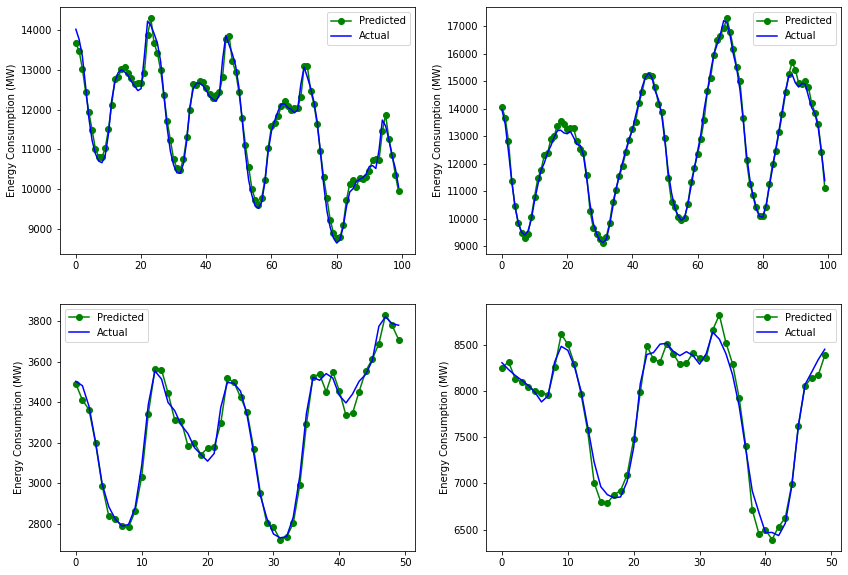

In [12]:
gru_outputs, targets, gru_sMAPE = evaluate(model, test_x, test_y, label_scalers)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[8][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="Predicted")
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(gru_outputs[6][:50], "-o", color="g", label="Predicted")
plt.plot(targets[6][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

## Exercises

We return to the tracking data and try to use the RNN concept to process it. This would seem a natural fit:  each datapoint is giving us more information we can use to update the initial track parameter prediction. In fact, tracking is usually done by a Kalman Filter which does exactly this, starting from an initial prediction it processes each hit to update the track parameters. In the Kalman Filter the track parameter updates are baked in based on our knowledge of the physics of charged particles passing through matter in a magnetic field (you propagate the particle from one hit plane to the next, updating the position uncertainties, then combine the new hit+uncertainty with the propagation+uncertainty to give the new state+(smaller) uncertainties), so essentially with the RNN we are asking the RNN to learn the necessary physics involved in propagation and detector response based on known examples.

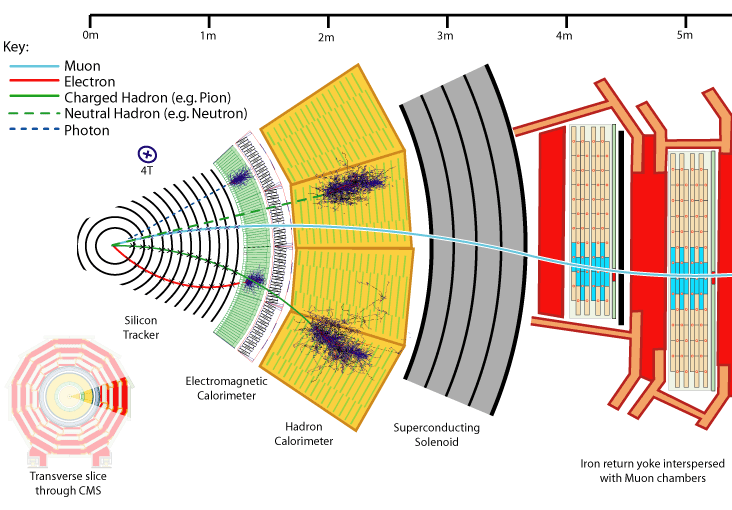

In [ ]:
from IPython.display import Image
Image('CMS_Slice-1.png')

Download the data and plot a track.

In [13]:
import numpy as np
import requests, io
resp=requests.get('https://cernbox.cern.ch/index.php/s/mLHcI8t0xhzWcRt/download', stream=True)
hits=np.load(io.BytesIO(resp.content))
x = hits['x']
y = hits['y']
x.shape, y.shape

((26000, 10, 3), (26000, 4))

array([ 2.20911646, -0.45175734,  0.20189908,  1.        ])

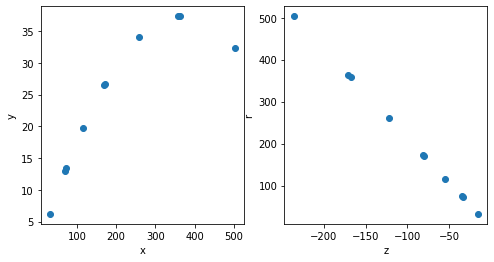

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(x[0,:,0], x[0,:,1])
plt.xlabel('x'), plt.ylabel('y')
plt.subplot(1,2,2)
plt.scatter(x[0,:,2], np.sqrt(x[0,:,0]**2 + x[0,:,1]**2))
plt.xlabel('z'), plt.ylabel('r')
y[0] # pt,eta,phi,q

Create test and training dataloaders which transform the raw data into a normalized form suitable for deep learning (so, preferably, values between -1,1 with mean 0 for each input/output axis). Use an 80% train 20% test split.

You could try using MinMax Scaler, or take the normalization from the given ranges:
- Inputs: `x` $\in [-1000,1000]$
- Outputs: `y[:,0]` is $p_T \in [1, 10]$ (units are GeV), `y[:,1]` is $\eta \in [-1,1]$, `y[:,2]` is $\phi \in [-\pi,\pi]$, `y[:,3]` is $q \in {-1,1}$

In [15]:
from sklearn.preprocessing import MinMaxScaler
  
x1 = x.copy()
y1 = y.copy()
print(x1.shape, y1.shape)

sc = MinMaxScaler()
sc_l = MinMaxScaler()
x1 = x1.reshape(-1,30)
x1 = sc.fit_transform(x1)
x1 = x1.reshape(-1,10,3)
y1 = sc_l.fit_transform(y1)
print(x1.shape, y1.shape)

(26000, 10, 3) (26000, 4)
(26000, 10, 3) (26000, 4)


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

'''
# Define lookback period and split inputs/labels
lookback = 30
inputs = np.zeros((len(x1)-lookback,lookback,x1.shape[1]))
labels = np.zeros((len(y1)-lookback,y1.shape[1]))

for i in range(lookback, len(x1)):
    inputs[i-lookback] = x1[i-lookback:i]
    labels[i-lookback] = y1[i]

inputs = inputs.reshape(-1,lookback,x1.shape[1])
labels = labels.reshape(-1,y1.shape[1])
'''

inputs = x1
labels = y1

# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.2*len(inputs))

train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]

batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

Create a `TrackNet` which uses a GRU or LSTM. It should be able to take in multiple instances of tracks, process them, then output the final track state. Use 2 hidden layers.

In [17]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.3):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [19]:
input_dim = next(iter(train_loader))[0].shape[2]
print(input_dim)
hidden_dim = 128
output_dim = 4
n_layers = 2
drop_prob = 0.3

device = torch.device('cuda')

TrackNet = GRUNet(input_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

3


Train the `TrackNet`, keep track of train and test losses each epoch to check that your network is learning. You should do a rough hyperparameter optimization to get a decently trained network. Use the sMAPE loss from the lecture or the MSELoss, as you like.

In [22]:
import time


def train(model, train_loader, learn_rate, hidden_dim=128, EPOCHS=10, model_type="GRU"):
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = model.init_hidden(batch_size)
            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%10 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [23]:
model = TrackNet
lr = 0.002

train(model, train_loader, lr, EPOCHS=50)

Starting Training of GRU model
Epoch 1......Step: 10/20....... Average Loss for Epoch: 0.0629879493266344
Epoch 1......Step: 20/20....... Average Loss for Epoch: 0.04830191694200039
Epoch 1/50 Done, Total Loss: 0.04830191694200039
Time Elapsed for Epoch: 0.3310791850000214 seconds
Epoch 2......Step: 10/20....... Average Loss for Epoch: 0.02379356846213341
Epoch 2......Step: 20/20....... Average Loss for Epoch: 0.021462423261255026
Epoch 2/50 Done, Total Loss: 0.021462423261255026
Time Elapsed for Epoch: 0.25499558399997113 seconds
Epoch 3......Step: 10/20....... Average Loss for Epoch: 0.016562598757445812
Epoch 3......Step: 20/20....... Average Loss for Epoch: 0.016818329365924
Epoch 3/50 Done, Total Loss: 0.016818329365924
Time Elapsed for Epoch: 0.24126740100007282 seconds
Epoch 4......Step: 10/20....... Average Loss for Epoch: 0.017816722765564917
Epoch 4......Step: 20/20....... Average Loss for Epoch: 0.016646796464920045
Epoch 4/50 Done, Total Loss: 0.016646796464920045
Time Elap

GRUNet(
  (gru): GRU(3, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
)

For the test set, plot the (unnormalized, so you'll need to undo your normalization transformation) difference between the reconstructed and true variables (the residual). It should be much better than when you tried this with a basic feedforward neural network.

In [24]:
def evaluate(model, test_loader, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.perf_counter()
    for inp, labs in test_loader:
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.extend(label_scalers.inverse_transform(out.cpu().detach().numpy()).reshape(-1).tolist())
        targets.extend(label_scalers.inverse_transform(labs.numpy()).reshape(-1).tolist())
    outputs = np.array(outputs).reshape(-1,4)
    targets = np.array(targets).reshape(-1,4)
    print("Evaluation Time: {}".format(str(time.perf_counter()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

Evaluation Time: 0.04192780699997911
sMAPE: 0.4349193407476874%


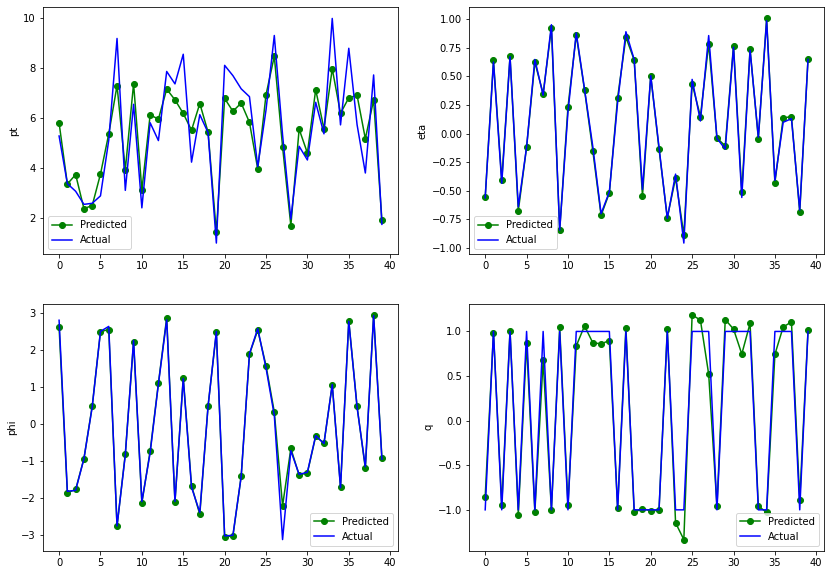

In [25]:
gru_outputs, targets, gru_sMAPE = evaluate(model, test_loader, label_scalers=sc_l)


plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(gru_outputs[:40,0], "-o", color="g", label="Predicted")
plt.plot(targets[:40,0], color="b", label="Actual")
plt.ylabel('pt')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[:40,1], "-o", color="g", label="Predicted")
plt.plot(targets[:40,1], color="b", label="Actual")
plt.ylabel('eta')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[:40,2], "-o", color="g", label="Predicted")
plt.plot(targets[:40,2], color="b", label="Actual")
plt.ylabel('phi')
plt.legend()

plt.subplot(2,2,4)
plt.plot(gru_outputs[:40,3], "-o", color="g", label="Predicted")
plt.plot(targets[:40,3], color="b", label="Actual")
plt.ylabel('q')
plt.legend()